# Tutorial 1: Materials Project Data Extraction for Photovoltaics

**Author**: Nabil Khossossi  

**Goal**: Extract photovoltaic-relevant materials from Materials Project database

## Overview

In this tutorial, we will:
1. Set up Materials Project API access
2. Query materials with optimal band gaps for solar cells
3. Filter by stability and composition
4. Extract specific material classes (e.g., perovskites)
5. Save data for downstream analysis

## Key Concepts

- **Band Gap**: The energy difference between valence and conduction bands (1.1-1.7 eV optimal for single junction)
- **Energy Above Hull**: Thermodynamic stability measure (< 0.1 eV/atom = stable)
- **Formation Energy**: Energy released during compound formation

## 1. Setup and Imports

In [1]:
# Standard imports
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Our custom modules
from data_extraction import MaterialsProjectExtractor

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Imports successful")

✓ Imports successful


## 2. Materials Project API Setup

### Getting Your API Key

1. Go to [materialsproject.org](https://materialsproject.org/)
2. Register for a free account
3. Navigate to Dashboard → API
4. Copy your API key

### Setting the API Key

**Option 1**: Environment variable (recommended)
```bash
export MP_API_KEY="your_key_here"
```

**Option 2**: Pass directly to constructor (for testing)

In [ ]:
# Initialize extractor
# If you have MP_API_KEY set as environment variable:
extractor = MaterialsProjectExtractor()

# Otherwise, pass your key directly:
extractor = MaterialsProjectExtractor(api_key="your_key_here")

print("✓ Materials Project API connected")

✓ Materials Project API connected


## 3. Query Photovoltaic Candidate Materials

### Selection Criteria

We'll search for materials with:
- **Band gap**: 1.1 - 1.7 eV (optimal for single junction solar cells)
- **Stability**: < 0.1 eV/atom above hull (thermodynamically stable)
- **Composition**: Binary to quaternary compounds (2-4 elements)
- **Exclusions**: Radioactive and highly toxic elements

In [3]:
# Query materials
df_pv = extractor.get_photovoltaic_candidates(
    bandgap_range=(1.1, 1.7),  # Optimal for single junction
    n_materials=100,
    stability_threshold=0.1,
    elements_to_exclude=['U', 'Th', 'Pu', 'Po', 'Hg']  # Radioactive and toxic
)

print(f"\nRetrieved {len(df_pv)} photovoltaic candidate materials")
print(f"\nFirst 5 materials:")
df_pv.head()

Querying Materials Project for PV candidates...
Band gap range: (1.1, 1.7) eV
Stability threshold: 0.1 eV/atom


Retrieving SummaryDoc documents:   0%|          | 0/7729 [00:00<?, ?it/s]

Retrieved 100 materials
Final dataset: 85 materials

Retrieved 85 photovoltaic candidate materials

First 5 materials:


,material_id,formula,band_gap,energy_above_hull,formation_energy,volume,density,crystal_system,space_group,is_stable,is_theoretical
0,mp-560328,Ag15P4S16Cl3,1.2888,0.000000,-0.481953,1709.591255,4.587131,Cubic,I-43d,True,False
1,mp-559071,Ag2Bi2S3Cl2,1.6368,0.004958,-0.748300,902.388610,5.894386,Triclinic,P-1,False,False
2,mp-556345,Ag2BrNO3,1.6045,0.019581,-0.655070,472.240735,5.030350,Orthorhombic,Pnma,False,False
3,mp-861942,Ag2GePbS4,1.3699,0.000000,-0.550359,364.725495,5.680462,Orthorhombic,Ama2,True,False
4,mp-690687,Ag2H2IOF,1.4591,0.000000,-1.046625,249.964486,5.044166,Monoclinic,P2_1,True,False


## 4. Exploratory Data Analysis

In [4]:
# Basic statistics
print("Dataset Statistics:")
print("=" * 60)
print(f"Total materials: {len(df_pv)}")
print(f"Band gap range: {df_pv['band_gap'].min():.2f} - {df_pv['band_gap'].max():.2f} eV")
print(f"Stable materials (E_hull < 0.05): {(df_pv['energy_above_hull'] < 0.05).sum()}")
print(f"\nCrystal systems:")
print(df_pv['crystal_system'].value_counts())

Dataset Statistics:
Total materials: 85
Band gap range: 1.12 - 1.70 eV
Stable materials (E_hull < 0.05): 82

Crystal systems:
crystal_system
Monoclinic      36
Orthorhombic    16
Triclinic        8
Trigonal         8
Tetragonal       8
Cubic            5
Hexagonal        4
Name: count, dtype: int64


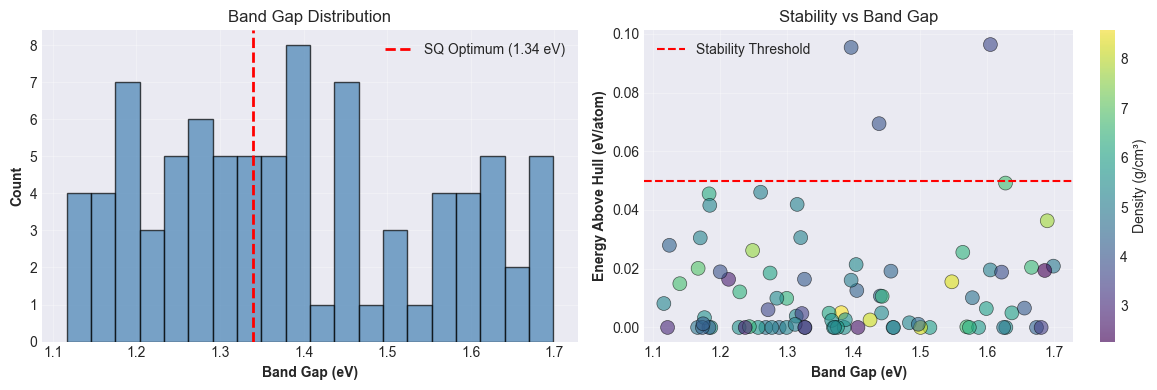

✓ Figure saved to figures/data_exploration.png


In [5]:
# Visualize band gap distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Band gap histogram
axes[0].hist(df_pv['band_gap'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(1.34, color='red', linestyle='--', linewidth=2, label='SQ Optimum (1.34 eV)')
axes[0].set_xlabel('Band Gap (eV)', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title('Band Gap Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Stability vs Band gap
scatter = axes[1].scatter(df_pv['band_gap'], df_pv['energy_above_hull'], 
                         c=df_pv['density'], cmap='viridis', 
                         s=100, alpha=0.6, edgecolors='black', linewidths=0.5)
axes[1].axhline(0.05, color='red', linestyle='--', label='Stability Threshold')
axes[1].set_xlabel('Band Gap (eV)', fontweight='bold')
axes[1].set_ylabel('Energy Above Hull (eV/atom)', fontweight='bold')
axes[1].set_title('Stability vs Band Gap')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Density (g/cm³)')

plt.tight_layout()
plt.savefig('../figures/data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved to figures/data_exploration.png")

## 5. Filter by Composition

Let's look at materials containing specific elements relevant to photovoltaics.

In [6]:
# Find materials with common PV elements
print("Materials containing Ga (Gallium):")
df_ga = extractor.filter_by_composition(df_pv, required_elements=['Ga'])
print(df_ga[['formula', 'band_gap', 'energy_above_hull']].head())

print("\nMaterials containing In (Indium):")
df_in = extractor.filter_by_composition(df_pv, required_elements=['In'])
print(df_in[['formula', 'band_gap', 'energy_above_hull']].head())

print("\nMaterials without Pb (Lead-free):")
df_pb_free = extractor.filter_by_composition(df_pv, forbidden_elements=['Pb'])
print(f"Found {len(df_pb_free)} lead-free materials")

Materials containing Ga (Gallium):
Empty DataFrame
Columns: [formula, band_gap, energy_above_hull]
Index: []

Materials containing In (Indium):
Empty DataFrame
Columns: [formula, band_gap, energy_above_hull]
Index: []

Materials without Pb (Lead-free):
Found 81 lead-free materials


## 6. Query Specific Material Classes: Perovskites

Halide perovskites are especially interesting for next-generation solar cells.

In [7]:
# Get halide perovskite materials
df_perovskite = extractor.get_perovskite_materials(
    perovskite_type='halide',
    n_materials=50
)

print(f"Found {len(df_perovskite)} halide perovskite materials")
print("\nTop 10 by band gap:")
print(df_perovskite[['formula', 'band_gap', 'energy_above_hull', 'crystal_system']].head(10))

Querying Materials Project for PV candidates...
Band gap range: (1.2, 2.5) eV
Stability threshold: 0.1 eV/atom


Retrieving SummaryDoc documents:   0%|          | 0/10000 [00:00<?, ?it/s]

Retrieved 100 materials
Final dataset: 85 materials
Found 2 halide perovskite materials

Top 10 by band gap:
        formula  band_gap  energy_above_hull crystal_system
1   Ag2Bi2S3Cl2    1.6368           0.004958      Triclinic
65   AgBi(IO3)4    2.4344           0.000000     Monoclinic


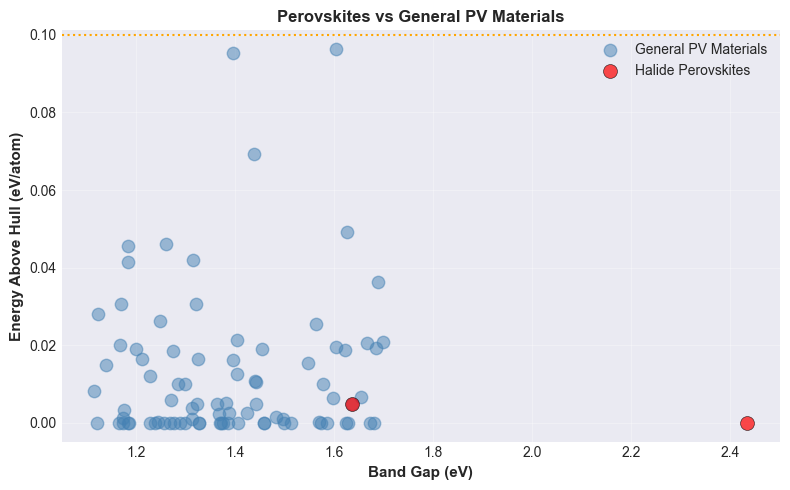

In [8]:
# Compare perovskites vs general PV materials
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(df_pv['band_gap'], df_pv['energy_above_hull'], 
          s=80, alpha=0.5, label='General PV Materials', color='steelblue')
ax.scatter(df_perovskite['band_gap'], df_perovskite['energy_above_hull'], 
          s=100, alpha=0.7, label='Halide Perovskites', color='red', 
          edgecolors='black', linewidths=0.5)

ax.set_xlabel('Band Gap (eV)', fontweight='bold', fontsize=11)
ax.set_ylabel('Energy Above Hull (eV/atom)', fontweight='bold', fontsize=11)
ax.set_title('Perovskites vs General PV Materials', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.axhline(0.1, color='orange', linestyle=':', label='Stability Threshold')

plt.tight_layout()
plt.savefig('../figures/perovskites_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Top Candidates Analysis

In [12]:
# Identify most promising candidates
# Criteria: band gap close to 1.34 eV and high stability

df_pv['bandgap_score'] = 1 - np.abs(df_pv['band_gap'] - 1.34) / 1.34
df_pv['stability_score'] = 1 / (1 + df_pv['energy_above_hull'])
df_pv['overall_score'] = df_pv['bandgap_score'] * df_pv['stability_score']

# Top 10 candidates
top_candidates = df_pv.nlargest(10, 'overall_score')

print("Top 10 Photovoltaic Candidate Materials:")
print("=" * 80)
print(top_candidates[[
    'formula', 'band_gap', 'energy_above_hull', 
    'crystal_system', 'overall_score'
]])

# Save top candidates
top_candidates.to_csv('../data/top_pv_candidates.csv', index=False)
print("\n✓ Top candidates saved to data/top_pv_candidates.csv")

Top 10 Photovoltaic Candidate Materials:
       formula  band_gap  energy_above_hull crystal_system  overall_score
7      Ag2PHO4    1.3274           0.000000       Trigonal       0.990597
77  Al(TeCl2)2    1.3271           0.000000   Orthorhombic       0.990373
61       AgPS3    1.3228           0.004740     Monoclinic       0.982507
66      AgSbS2    1.3127           0.001051     Monoclinic       0.978598
14        Ag2S    1.3634           0.004851     Monoclinic       0.977794
3    Ag2GePbS4    1.3699           0.000000   Orthorhombic       0.977687
53         AgI    1.3674           0.002407          Cubic       0.977201
56         AgI    1.3143           0.003859     Tetragonal       0.977051
67      AgSbS2    1.3716           0.000000     Monoclinic       0.976418
59  AgP(XeF5)2    1.3266           0.016416     Tetragonal       0.974011

✓ Top candidates saved to data/top_pv_candidates.csv


## 8. Save Complete Dataset

In [13]:
# Save all datasets
extractor.save_data(df_pv, 'pv_candidates_all.csv')
extractor.save_data(df_perovskite, 'halide_perovskites.csv')

print("\n✓ All data saved to data/raw/")
print(f"  - pv_candidates_all.csv ({len(df_pv)} materials)")
print(f"  - halide_perovskites.csv ({len(df_perovskite)} materials)")
print(f"  - top_pv_candidates.csv ({len(top_candidates)} materials)")

Data saved to data/raw/pv_candidates_all.csv
Data saved to data/raw/halide_perovskites.csv

✓ All data saved to data/raw/
  - pv_candidates_all.csv (85 materials)
  - halide_perovskites.csv (2 materials)
  - top_pv_candidates.csv (10 materials)


## 9. Summary and Next Steps

### What We Accomplished

- ✓ Connected to Materials Project API
- ✓ Queried ~100 photovoltaic candidate materials
- ✓ Filtered by band gap, stability, and composition
- ✓ Identified halide perovskite materials
- ✓ Ranked materials by combined band gap and stability score
- ✓ Saved datasets for further analysis

### Next Steps

In the next tutorials, we will:
1. **Tutorial 2**: Compute physics-based descriptors (electronic, optical, thermodynamic)
2. **Tutorial 3**: Build ML models with physical constraints
3. **Tutorial 4**: Interpret predictions and identify new candidates

### Key Takeaways

- Materials Project provides extensive materials data for free
- Optimal single junction band gap ≈ 1.34 eV (Shockley-Queisser)
- Thermodynamic stability (energy above hull) is crucial for synthesizability
- Halide perovskites show promise but often have stability challenges
- ~10-20% of queried materials meet strict stability criteria

### References

1. Materials Project: https://materialsproject.org/
2. Shockley, W. & Queisser, H. J. *J. Appl. Phys.* **32**, 510 (1961)
3. Zhang, J. *et al.* *Acc. Chem. Res.* **57**, 1434 (2024) - Device Acceleration Platforms